In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [ ]:
# Dowload the dataset
dataset_url="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
        
data_dir = './data/cifar10'

# Look inside the dataset directory
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['test', 'train', 'models']
['deer', 'automobile', 'frog', 'truck', 'dog', 'bird', 'airplane', 'cat', 'horse', 'ship']


In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
# PyTorch datasets
data_dir = './data/cifar10'
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

Next, we can create data loaders for retrieving images in batches.

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 100

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, 
                      num_workers=8, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


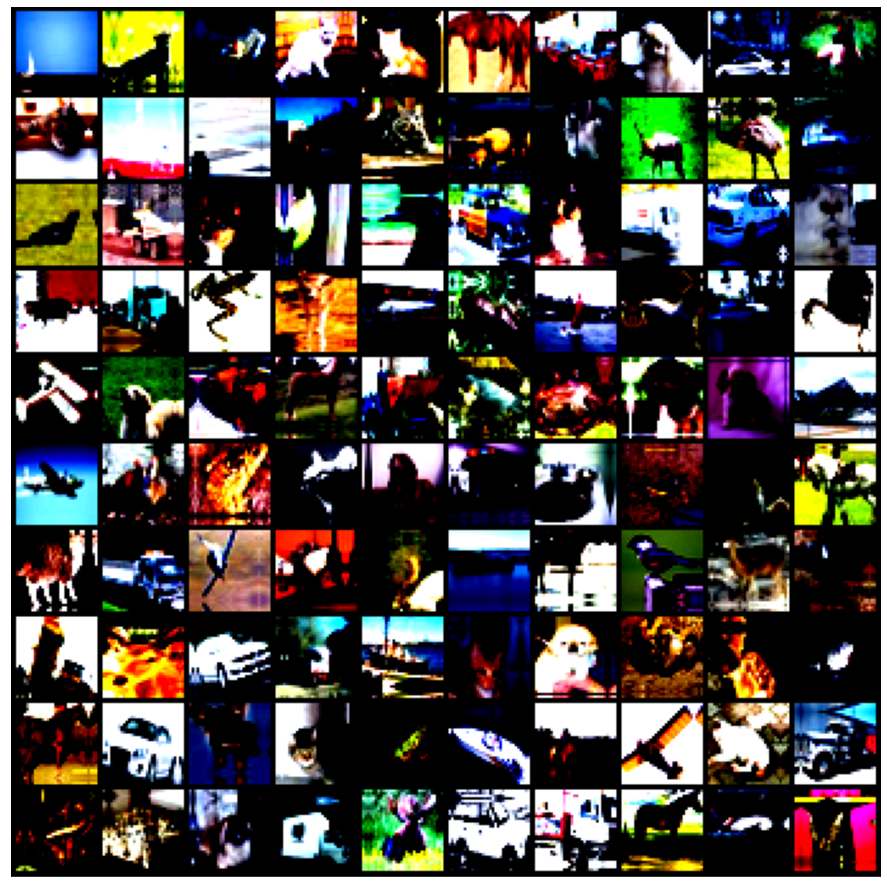

In [ ]:
show_batch(train_dl)

## Model with Residual Blocks and Batch Normalization
WideResNet22: which has 22 convolutional layers. 
<img src="https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png">


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out + x)

In [ ]:
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

torch.Size([100, 3, 32, 32])


<img src="https://miro.medium.com/max/2500/1*gOyiFYGHMAEDlyoAIhkWkA.png">


In [ ]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [ ]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def wrn_22(): 
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [ ]:
model = wrn_22()

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 10])


In [ ]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

First, we create a `DataBunch` object to using the data loaders we created previously, and then we create a `Learner` object using the data bunch, model and a loss function.

In [ ]:
data = DataBunch.create(train_ds, valid_ds, bs=batch_size, path='./data/cifar10')
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


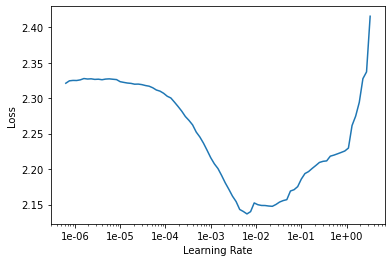

In [ ]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(9, 5e-3, wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.112910,1.180511,0.595200,01:57
1,0.915551,0.978275,0.663800,01:57
2,0.683213,0.781061,0.735200,01:57
3,0.532349,0.553710,0.812800,01:57
4,0.424663,0.423530,0.856100,01:57
5,0.337453,0.375039,0.877400,01:57
6,0.244131,0.299711,0.901800,01:57
7,0.187466,0.264437,0.917700,01:57
8,0.153371,0.258821,0.916900,01:57


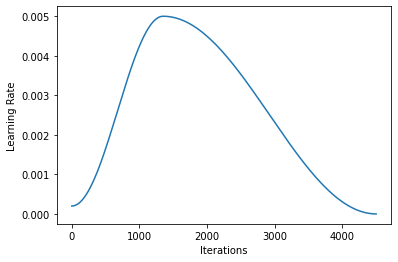

In [ ]:
learner.recorder.plot_lr()

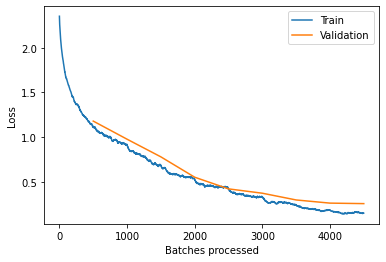

In [ ]:
learner.recorder.plot_losses()

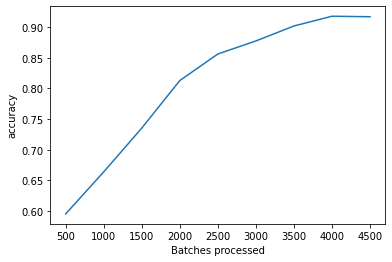

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)